### 대주제: 대전광역시 교통사고 분석
#### 소주제1: 시간대별 교통사고 분석
#### 핵심 아이디어1: 시간대별로 교통사고 발생에 차이가 존재하는데 그 차이가 사건종별로도 유의한 차이가 있는지, 구별로도 유의한 차이가 있는지 궁금함

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import math

#한글 깨짐 방지 코드
from matplotlib import rc, style, font_manager
font_name = font_manager.FontProperties(fname="C:/windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
style.use('ggplot')

In [2]:
import pandas as pd

df = pd.read_csv("C:/Users/koaro/치안안전데이터분석공모전/최종전처리.csv", encoding='euc-kr')

#### 대전광역시의 시간대별로 교통사고 발생횟수에는 차이가 있음 

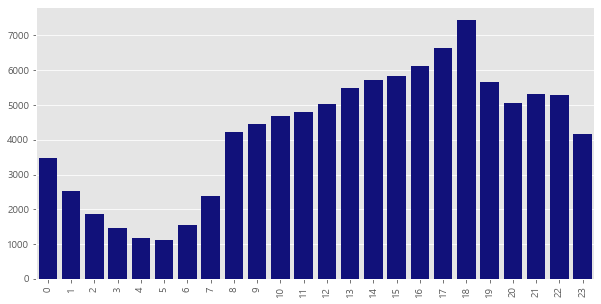

In [6]:
value_counts = df['접수완료시간'].value_counts()

plt.figure(figsize=(10,5))
sns.barplot(x=value_counts.index, y=value_counts.values,color='darkblue')
plt.xticks(rotation=90)
plt.show();

In [7]:
df1 = df[df['접수완료시간'].isin([0, 1, 2, 3, 4, 5, 6, 7])]
df2 = df[~df['접수완료시간'].isin([0, 1, 2, 3, 4, 5, 6, 7])]
print(df1['접수완료시간'].unique())
print(df2['접수완료시간'].unique())

[1 5 3 7 6 0 2 4]
[13 20 21 18 15 17 14 16 11 19 22  9 10  8 23 12]


In [13]:
df1 = df1.groupby(['접수완료시간']).size().reset_index(name='발생횟수')
df2 = df2.groupby(['접수완료시간']).size().reset_index(name='발생횟수')

#### 0-7 시간대와 그렇지 않은 시간대 간에는 차이가 존재하는지 검정

In [139]:
import scipy.stats as stats

alpha = 0.05

_, p1 = stats.shapiro(df1['발생횟수'])
_, p2 = stats.shapiro(df2['발생횟수'])

if p1 > alpha and p2 > alpha:
    # t-test or Welch's t-test
    print('검정 방법: t검정')
    t, p = stats.ttest_ind(df1['발생횟수'], df2['발생횟수'], equal_var=False)
    print('p-value:', p)
    if p < alpha:
        print('The two columns are significantly different.')
    else:
        print('The two columns are not significantly different.')
else:
    # Mann-Whitney U test
    u, p = stats.mannwhitneyu(df1['발생횟수'], df2['발생횟수'])
    print('검정 방법: Welchs t검정')
    print('p-value:', p)
    if p < alpha:
        print('The two columns are significantly different.')
    else:
        print('The two columns are not significantly different.')


검정 방법: t검정
p-value: 8.330387034700644e-08
The two columns are significantly different.


#### 두 시간대 사이에는 유의한 차이가 존재함

### (1) 0-7시를 심야시간대라고 정의하고, 심야시간대의 교통사고 요인분석

#### -시군구에 따른 발생횟수 차이가 있는지 검정

In [3]:
sido = df[df['접수완료시간'].isin([0, 1, 2, 3, 4, 5, 6, 7])]
sido = sido.groupby(['접수완료시간','시군구']).size().reset_index(name='발생횟수')

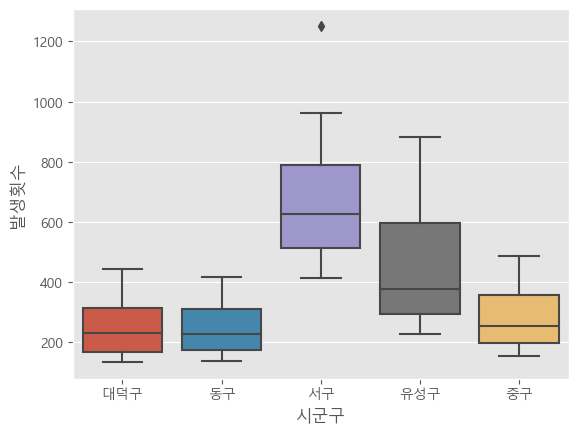

In [4]:
sns.boxplot(x="시군구", y="발생횟수", data=sido)
plt.show();

In [5]:
import scipy.stats as stats

grouped = sido.groupby("시군구")["발생횟수"]
f_val, p_val = stats.f_oneway(*[grouped.get_group(x) for x in grouped.groups])
print("F-value: ", f_val)
print("P-value: ", p_val)
if p_val > 0.05:
    print('not reject H0')
else:
    print('reject H0')

F-value:  8.963054171438703
P-value:  4.302025670865929e-05
reject H0


#### 시군구별로 발생횟수에는 유의한 차이 존재

In [75]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(sido['발생횟수'], sido['시군구'])
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
대덕구,동구,-9.0,0.9,-272.1254,254.1254,False
대덕구,서구,444.5,0.001,181.3746,707.6254,True
대덕구,유성구,194.25,0.2336,-68.8754,457.3754,False
대덕구,중구,25.625,0.9,-237.5004,288.7504,False
동구,서구,453.5,0.001,190.3746,716.6254,True
동구,유성구,203.25,0.1959,-59.8754,466.3754,False
동구,중구,34.625,0.9,-228.5004,297.7504,False
서구,유성구,-250.25,0.0689,-513.3754,12.8754,False
서구,중구,-418.875,0.001,-682.0004,-155.7496,True
유성구,중구,-168.625,0.3672,-431.7504,94.5004,False


#### 특히, 서구에 유의한 차이 존재

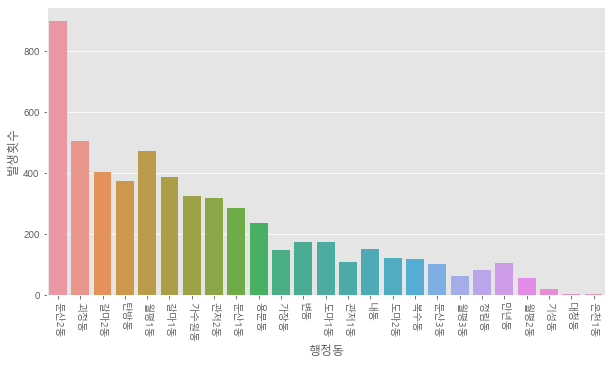

In [80]:
seogu = df[df['접수완료시간'].isin([0, 1, 2, 3, 4, 5, 6, 7])]
seogu = seogu.groupby(['시군구','행정동','접수완료시간']).size().reset_index(name='발생횟수')
seogu = seogu.sort_values(by='발생횟수',ascending=False)

plt.figure(figsize=(10,5))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)
sns.barplot(x='행정동',y='발생횟수',data=seogu[seogu['시군구']=='서구'],estimator=sum, ci=None)
plt.xticks(rotation=-90, fontsize=10)
plt.show();

#### 다만, 서구내에서도 둔산2동의 영향이 큰 것으로 보임
#### 서구 내에서도 발생횟수에 차이가 있는지 없는지 확인할 필요가 있어보임

In [81]:
import scipy.stats as stats

alpha = 0.05

donsan2 = seogu[seogu['행정동'] == '둔산2동']['발생횟수']
others = seogu[seogu['행정동'] != '둔산2동']['발생횟수']

_, p1 = stats.shapiro(donsan2)
_, p2 = stats.shapiro(others)

if p1 > alpha and p2 > alpha:
    # t-test or Welch's t-test
    t, p = stats.ttest_ind(donsan2, others, equal_var=False)
    print('p-value:', p)
    if p < alpha:
        print('The two groups are significantly different.')
    else:
        print('The two groups are not significantly different.')
else:
    # Mann-Whitney U test
    u, p = stats.mannwhitneyu(donsan2, others)
    print('p-value:', p)
    if p < alpha:
        print('The two groups are significantly different.')
    else:
        print('The two groups are not significantly different.')

p-value: 1.5250693927619076e-06
The two groups are significantly different.


#### 독립성 검정결과, 차이 존재

#### 둔산2동을 제외하고 검정 

In [88]:
sido2 = df[~df['행정동'].isin(['둔산2동'])]
sido2 = sido2[sido2['접수완료시간'].isin([0, 1, 2, 3, 4, 5, 6, 7])]
sido2 = sido2.groupby(['접수완료시간','시군구']).size().reset_index(name='발생횟수')

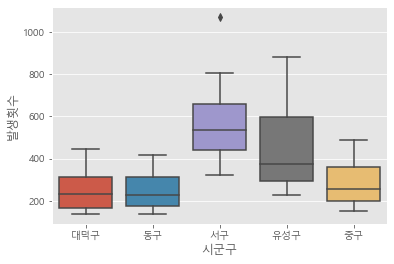

F-value:  5.9701764071999674
P-value:  0.0009016128356318897
reject H0


In [89]:
sns.boxplot(x="시군구", y="발생횟수", data=sido2)
plt.show();

import scipy.stats as stats

grouped = sido2.groupby("시군구")["발생횟수"]
f_val, p_val = stats.f_oneway(*[grouped.get_group(x) for x in grouped.groups])
print("F-value: ", f_val)
print("P-value: ", p_val)
if p_val > 0.05:
    print('not reject H0')
else:
    print('reject H0')

#### 둔산2동을 제외했을 때도 시군구간 차이 존재

In [106]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(sido2['발생횟수'], sido2['시군구'])
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
대덕구,동구,-9.0,0.9,-258.2643,240.2643,False
대덕구,서구,332.0,0.0044,82.7357,581.2643,True
대덕구,유성구,194.25,0.1889,-55.0143,443.5143,False
대덕구,중구,25.625,0.9,-223.6393,274.8893,False
동구,서구,341.0,0.0033,91.7357,590.2643,True
동구,유성구,203.25,0.1553,-46.0143,452.5143,False
동구,중구,34.625,0.9,-214.6393,283.8893,False
서구,유성구,-137.75,0.5124,-387.0143,111.5143,False
서구,중구,-306.375,0.0097,-555.6393,-57.1107,True
유성구,중구,-168.625,0.3136,-417.8893,80.6393,False


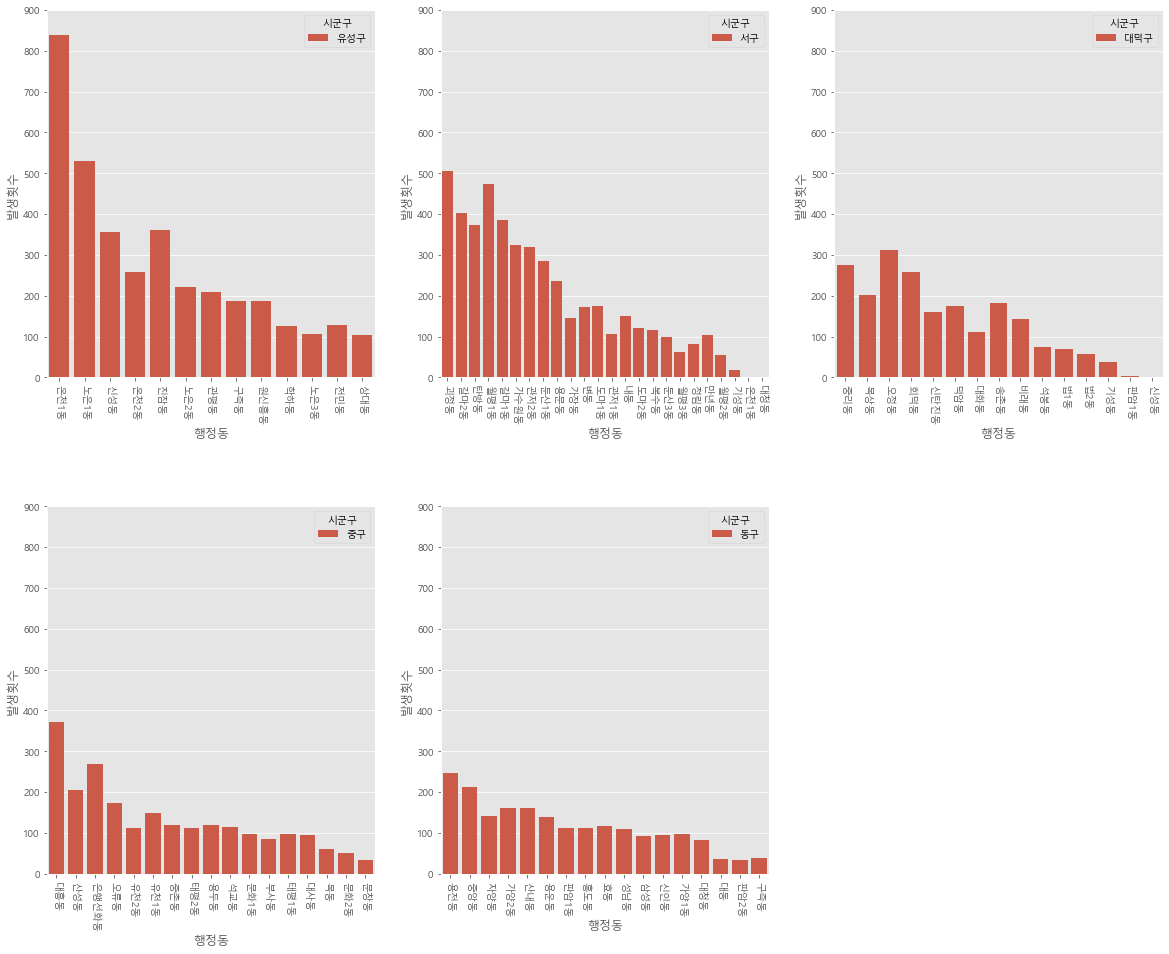

In [95]:
df_col3 = df[~df['행정동'].isin(['둔산2동'])]
df_col3 = df_col3[df_col3['접수완료시간'].isin([0, 1, 2, 3, 4, 5, 6, 7])]
df_col3 = df_col3.groupby(['시군구','행정동','접수완료시간']).size().reset_index(name='발생횟수')
df_col3.sort_values(by='발생횟수',ascending=False,inplace=True)

plt.figure(figsize=(20,15))
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.35)

ax1 = plt.subplot(2,3,1)
sns.barplot(x='행정동',y='발생횟수',data=df_col3[df_col3['시군구']=='유성구'],hue='시군구',estimator=sum, ci=None)
plt.xticks(rotation=-90, fontsize=10)
plt.ylim([0,900])

ax2 = plt.subplot(2,3,2)
sns.barplot(x='행정동',y='발생횟수',data=df_col3[df_col3['시군구']=='서구'],hue='시군구',estimator=sum, ci=None)
plt.xticks(rotation=-90,fontsize=10)
plt.ylim([0,900])

ax3 = plt.subplot(2,3,3)
sns.barplot(x='행정동',y='발생횟수',data=df_col3[df_col3['시군구']=='대덕구'],hue='시군구',estimator=sum, ci=None)
plt.xticks(rotation=-90,fontsize=10)
plt.ylim([0,900])

ax4 = plt.subplot(2,3,4)
sns.barplot(x='행정동',y='발생횟수',data=df_col3[df_col3['시군구']=='중구'],hue='시군구',estimator=sum, ci=None)
plt.xticks(rotation=-90,fontsize=10)
plt.ylim([0,900])

ax5 = plt.subplot(2,3,5)
sns.barplot(x='행정동',y='발생횟수',data=df_col3[df_col3['시군구']=='동구'],hue='시군구',estimator=sum, ci=None)
plt.xticks(rotation=-90,fontsize=10)
plt.ylim([0,900])

plt.show();

#### 서구가 유의한 평균차가 존재함
#### 따라서 서구 지역의 시간대별, 사건종별로 세분화하여 분석할 필요가 있음

#### -서구의 사건종별 시간대별 구분에 따른 교통사고 발생횟수 확인
#### 독립변수: 사건종별, 시간대별, 행정동
#### 종속변수: 발생횟수 

In [114]:
df_seogu = df[df['시군구']=='서구']
df_seogu = df_seogu[df_seogu['접수완료시간'].isin([0, 1, 2, 3, 4, 5, 6, 7])]
df_seogu = df_seogu.groupby(['사건종별','접수완료시간']).size().reset_index(name='발생횟수')

In [124]:
df_seogu = df_seogu[df_seogu['사건종별'] != 405]

In [136]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('발생횟수 ~ C(사건종별)+C(접수완료시간)', data=df_seogu).fit()
result = sm.stats.anova_lm(model)
pd.DataFrame(result)

,df,sum_sq,mean_sq,F,PR(>F)
C(사건종별),3.0,462384.25,154128.083333,17.290633,0.000007
C(접수완료시간),7.0,137476.50,19639.500000,2.203228,0.076265
Residual,21.0,187193.25,8913.964286,NaN,NaN


#### 서구의 경우, 사건종별 시간대별 구분에 의하면, 사건종별에 차이가 존재하지만, 시간대별로는 발생에 차이가 존재하지 않는다

In [164]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(df_seogu['발생횟수'], df_seogu['사건종별'])
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
401,402,-245.25,0.001,-392.2522,-98.2478,True
401,403,-267.125,0.001,-414.1272,-120.1228,True
401,406,-35.125,0.9,-182.1272,111.8772,False
402,403,-21.875,0.9,-168.8772,125.1272,False
402,406,210.125,0.0029,63.1228,357.1272,True
403,406,232.0,0.001,84.9978,379.0022,True


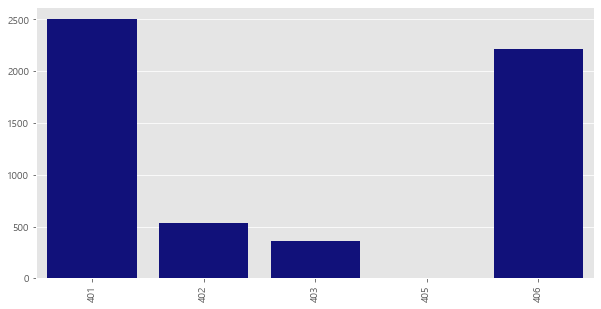

In [170]:
count = df_seogu['사건종별'].value_counts()

plt.figure(figsize=(10,5))
sns.barplot(x=count.index, y=count.values,color='darkblue')
plt.xticks(rotation=90)
plt.show();

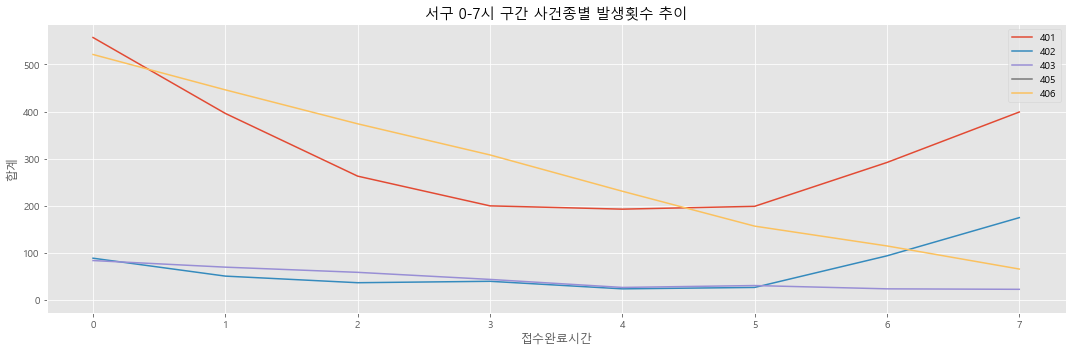

In [118]:
fig, ax = plt.subplots(figsize=(15, 5))

for name, group in df_seogu.groupby('사건종별'):
    group.plot(x='접수완료시간', y='발생횟수', kind='line', ax=ax, label=name)
    
    ax.set_title('서구 0-7시 구간 사건종별 발생횟수 추이')
    ax.set_xlabel('접수완료시간')
    ax.set_ylabel('합계')
    ax.legend()

plt.tight_layout()
plt.show()

#### -서구의 행정동 구분에 따른 교통사고 발생횟수 확인 

In [33]:
df_col11 = df[df['접수완료시간'].isin([0, 1, 2, 3, 4, 5, 6, 7])]
df_col11 = df_col11.groupby(['시군구','접수완료시간']).size().reset_index(name='발생횟수')

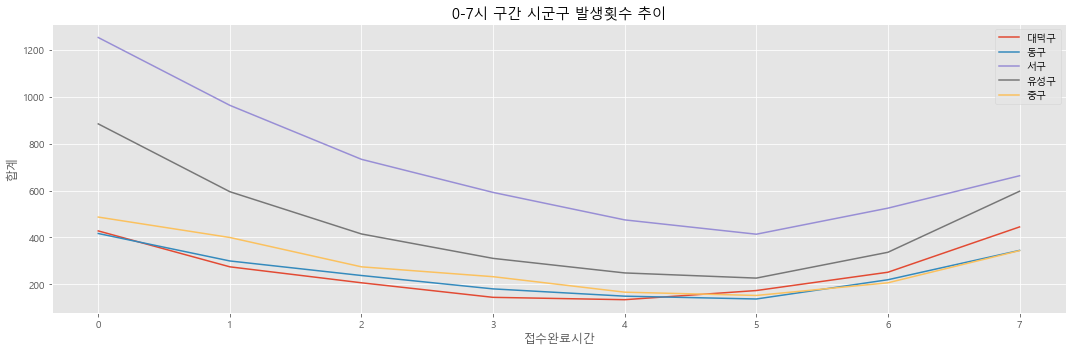

In [34]:
fig, ax = plt.subplots(figsize=(15, 5))

for name, group in df_col11.groupby('시군구'):
    group.plot(x='접수완료시간', y='발생횟수', kind='line', ax=ax, label=name)
    
    ax.set_title('0-7시 구간 시군구 발생횟수 추이')
    ax.set_xlabel('접수완료시간')
    ax.set_ylabel('합계')
    ax.legend()

plt.tight_layout()
plt.show()

#### 시군구, 사건종별 구분에 따른 발생횟수 확인

In [43]:
df_col12 = df[df['접수완료시간'].isin([0, 1, 2, 3, 4, 5, 6, 7])]
df_col12 = df_col12.groupby(['사건종별','시군구','행정동','총인구수','면적','접수완료시간']).size().reset_index(name='발생횟수')

In [45]:
df_col12.sort_values(by='발생횟수',ascending=False)

,사건종별,시군구,행정동,총인구수,면적,접수완료시간,발생횟수
471,401,유성구,온천1동,26336,12.90,0,105
1917,406,유성구,온천1동,26336,12.90,1,79
1916,406,유성구,온천1동,26336,12.90,0,77
472,401,유성구,온천1동,26336,12.90,1,74
1787,406,서구,둔산2동,35277,2.40,0,70
...,...,...,...,...,...,...,...
1103,403,대덕구,신탄진동,14618,22.98,4,1
1684,406,동구,홍도동,10604,0.63,6,1
1108,403,대덕구,오정동,14022,3.08,3,1
1116,403,대덕구,중리동,19055,1.50,4,1


In [162]:
aosd = df.groupby(['사건종별','접수완료시간']).size().reset_index(name='발생횟수')
aosd = aosd[~aosd['사건종별'].isin([401])]

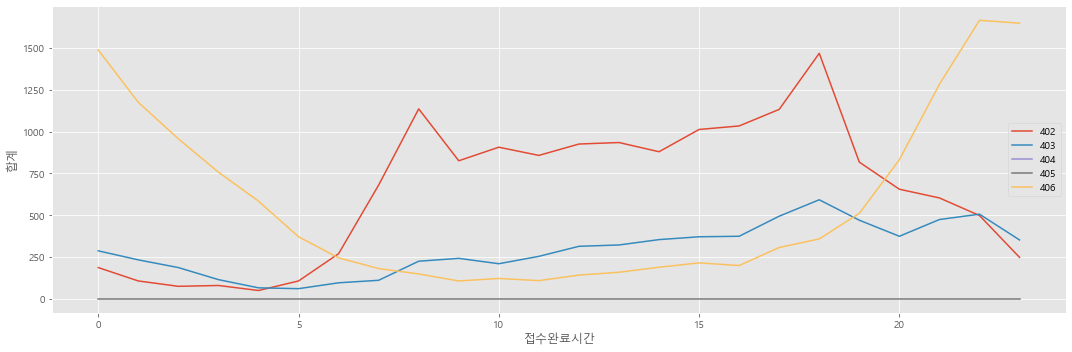

In [163]:
fig, ax = plt.subplots(figsize=(15, 5))

for name, group in aosd.groupby('사건종별'):
    group.plot(x='접수완료시간', y='발생횟수', kind='line', ax=ax, label=name)

ax.set_ylabel('합계')
ax.legend()
plt.tight_layout()
plt.show()

### 모델링 부활...?

In [187]:
df3 = df.copy()

def convert_to_time_of_day(hour):
    if hour in [0,1,2,3,4,5,6,7]:
        return '심야'
    elif hour in [8,9,10,11,12,13,14,15,16,17]:
        return '주간'
    else:
        return '야간'

df3['주야간구분'] = df3['접수완료시간'].apply(convert_to_time_of_day)

df3['강수량'] = df3['강수량'].apply(lambda x: 0 if pd.isnull(x) else 1)
df3['적설'] = df3['적설'].apply(lambda x: 0 if pd.isnull(x) else 1)

df_count = df3.groupby(['사건종별','시군구','행정동','인구밀도','노인인구','유소년인구','요일','주야간구분','적설','강수량','계절']).size().reset_index(name='발생횟수')
df_count.sort_values(by='발생횟수',ascending=False)

,사건종별,시군구,행정동,인구밀도,노인인구,유소년인구,요일,주야간구분,적설,강수량,계절,발생횟수
13023,402,서구,둔산2동,14698.750000,3601,4693,토요일,주간,0,0,겨울,105
7527,401,유성구,온천1동,2041.550388,3708,1161,수요일,주간,0,0,가을,68
7504,401,유성구,온천1동,2041.550388,3708,1161,목요일,주간,0,0,가을,68
7480,401,유성구,온천1동,2041.550388,3708,1161,금요일,주간,0,0,봄,64
6919,401,유성구,노은1동,2327.391304,2277,3350,토요일,주간,0,0,가을,63
...,...,...,...,...,...,...,...,...,...,...,...,...
13923,402,유성구,노은1동,2327.391304,2277,3350,화요일,심야,0,1,가을,1
13929,402,유성구,노은1동,2327.391304,2277,3350,화요일,야간,0,1,봄,1
13938,402,유성구,노은2동,2042.284740,2883,3581,금요일,심야,0,0,겨울,1
13940,402,유성구,노은2동,2042.284740,2883,3581,금요일,심야,0,0,여름,1


In [183]:
df_count.corr()

,사건종별,인구밀도,노인인구,유소년인구,적설,강수량,발생횟수
사건종별,1.000000,-0.013722,0.002299,0.017487,-0.157396,-0.079281,-0.194349
인구밀도,-0.013722,1.000000,0.044345,0.010891,-0.006167,0.000562,-0.027096
노인인구,0.002299,0.044345,1.000000,0.378825,0.022793,0.022527,0.034634
유소년인구,0.017487,0.010891,0.378825,1.000000,0.023954,0.032840,0.044904
적설,-0.157396,-0.006167,0.022793,0.023954,1.000000,-0.056829,-0.165217
강수량,-0.079281,0.000562,0.022527,0.032840,-0.056829,1.000000,-0.242144
발생횟수,-0.194349,-0.027096,0.034634,0.044904,-0.165217,-0.242144,1.000000


#### 사건종별로 발생횟수에 차이가 있다

In [184]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

df_401 = df_count[df_count['사건종별'] == 401]
df_402 = df_count[df_count['사건종별'] == 402]
df_403 = df_count[df_count['사건종별'] == 403]
df_406 = df_count[df_count['사건종별'] == 406]

stat, p = stats.normaltest(df_401['발생횟수'])
print("401: Statistics=%.3f, p=%.4f" % (stat, p))
stat, p = stats.normaltest(df_402['발생횟수'])
print("402: Statistics=%.3f, p=%.4f" % (stat, p))
stat, p = stats.normaltest(df_403['발생횟수'])
print("403: Statistics=%.3f, p=%.4f" % (stat, p))
stat, p = stats.normaltest(df_406['발생횟수'])
print("406: Statistics=%.3f, p=%.4f" % (stat, p))

401: Statistics=2839.215, p=0.0000
402: Statistics=3238.634, p=0.0000
403: Statistics=1306.318, p=0.0000
406: Statistics=2077.596, p=0.0000


In [185]:
from scipy.stats import kruskal

df_new_401 = df_count[df_count['사건종별'] == 401]['발생횟수']
df_new_402 = df_count[df_count['사건종별'] == 402]['발생횟수']
df_new_403 = df_count[df_count['사건종별'] == 403]['발생횟수']
df_new_406 = df_count[df_count['사건종별'] == 406]['발생횟수']

stat, p = kruskal(df_new_401, df_new_402, df_new_403, df_new_406)

print('검정통계량:',stat)
print('p-value:',p)
print('-'*50)
if p < 0.05:
    print("H0 reject")
else:
    print("Fail to reject H0")

검정통계량: 665.4920362573417
p-value: 6.373868089506173e-144
--------------------------------------------------
H0 reject


In [186]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(data = df_count.발생횟수, groups = df_count.사건종별)
print(mc.tukeyhsd())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
   401    402  -9.8518  0.001 -11.0568  -8.6469   True
   401    403 -12.2462  0.001 -13.5624 -10.9299   True
   401    404 -14.8783    0.9 -62.7899  33.0334  False
   401    405 -14.8783 0.2535   -34.45   4.6935  False
   401    406 -10.0974  0.001 -11.3316  -8.8632   True
   402    403  -2.3943  0.001  -3.8312  -0.9575   True
   402    404  -5.0264    0.9 -52.9415  42.8887  False
   402    405  -5.0264    0.9 -24.6067  14.5538  False
   402    406  -0.2456    0.9  -1.6077   1.1166  False
   403    404  -2.6321    0.9 -50.5501  45.2859  False
   403    405  -2.6321    0.9 -22.2195  16.9553  False
   403    406   2.1488  0.001   0.6872   3.6103   True
   404    405      0.0    0.9 -51.7442  51.7442  False
   404    406   4.7809    0.9  -43.135  52.6967  False
   405    406   4.7809    0.9 -14.8012  24.3629  False
----------

#### 모델링 전처리

In [189]:
df_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24622 entries, 0 to 24621
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   사건종별    24622 non-null  int64  
 1   시군구     24622 non-null  object 
 2   행정동     24622 non-null  object 
 3   인구밀도    24622 non-null  float64
 4   노인인구    24622 non-null  int64  
 5   유소년인구   24622 non-null  int64  
 6   요일      24622 non-null  object 
 7   주야간구분   24622 non-null  object 
 8   적설      24622 non-null  int64  
 9   강수량     24622 non-null  int64  
 10  계절      24622 non-null  object 
 11  발생횟수    24622 non-null  int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 2.3+ MB


#### 사건종별, 인구밀도, 노인인구, 유소년인구, 요일, 주야간구분, 적설, 강수량 유무, 계절을 변수로 사용

In [190]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# One-hot encoding
encoder = OneHotEncoder()
encoded_columns = encoder.fit_transform(df_count[['사건종별', '적설', '강수량']])
df_one_hot = pd.DataFrame(encoded_columns.toarray(), columns=encoder.get_feature_names(['사건종별', '적설', '강수량']))
df_count = pd.concat([df_count.drop(['사건종별', '적설', '강수량'], axis=1), df_one_hot], axis=1)

# Label encoding
encoder = LabelEncoder()
df_count['요일'] = encoder.fit_transform(df_count['요일'])
df_count['주야간구분'] = encoder.fit_transform(df_count['주야간구분'])
df_count['계절'] = encoder.fit_transform(df_count['계절'])

In [193]:
df_count = df_count.iloc[:,2:]

In [ ]:
X_train,X_test,y_train,y_test 